In [8]:
import numpy as np
import matplotlib.pyplot as plt

import supervisely_lib as sly

from tqdm import tqdm
from collections import defaultdict

%matplotlib inline

In [9]:
address = 'http://192.168.1.69:5555'
token = 'YGPDnuBkhFmcQ7VNzSEjhgavjg4eFR4Eq1C3jIY4HgV3SQq2JgkXCNtgZy1Fu2ftd4IKui8DsjrdtXjB853cMtBevpSJqFDYiaG1A5qphlH6fFiYYmcVZ5fMR8dDrt5l'
team_name = 'dima'
workspace_name = 'work'

src_project_name = 'roads_inf'

In [10]:
api = sly.Api(address, token)

team_id = api.team.get_info_by_name(team_name)['id']
workspace_id = api.workspace.get_info_by_name(workspace_name, team_id)['id']

src_project_id = api.project.get_info_by_name(src_project_name, workspace_id)['id']

src_meta_json = api.project.get_meta(src_project_id)
src_meta = sly.ProjectMeta.from_json(src_meta_json)

In [11]:
classes_mapping = {
    'road': 'road_unet'
}

In [12]:
def iou(mask_1, mask_2):
    intersection = (mask_1 * mask_2).sum()
    union = mask_1.sum() + mask_2.sum() - intersection
    if union == 0:
        return 0.0
    return intersection / union


def process(ann, metric_res):
    img_size = ann.img_size
    for cls_gt, cls_pred in classes_mapping.items():
        gt_mask = np.zeros(img_size, np.uint8)
        pred_mask = np.zeros(img_size, np.uint8)
        for label in ann.labels:
            if label.obj_class.name == cls_gt:
                label.geometry.draw(gt_mask, 1)
            if label.obj_class.name == cls_pred:
                label.geometry.draw(pred_mask, 1)
                
        iou_value = iou(gt_mask, pred_mask)
        metric_res[cls_gt + ':' + cls_pred].append(iou_value)

In [13]:
metric_results = defaultdict(list)
for dataset_info in api.dataset.get_list(src_project_id):
    src_dataset_id = dataset_info['id']
    src_dataset_name = dataset_info['title']

    print('Project/Dataset: {}/{}'.format(src_project_name, src_dataset_name))
    
    for image_info in tqdm(api.image.get_list(src_dataset_id)):
        src_image_ext = image_info['meta']['mime'].split('/')[1]

        ann_json = api.annotation.download(src_dataset_id, image_info['id'])
        ann = sly.Annotation.from_json(ann_json, src_meta)
        process(ann, metric_results)

 40%|████      | 4/10 [00:00<00:00, 31.35it/s]

Project/Dataset: roads_inf/ds1


100%|██████████| 10/10 [00:00<00:00, 31.66it/s]


Mean IoU value for classes 'road' and 'road_unet': 0.699471976387098
Distribution of IoU values:


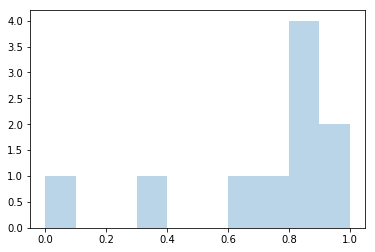

Average for all classes.
Intersection over union value: 0.699471976387098


In [21]:
all_means = []
for cls_gt, cls_pred in classes_mapping.items():
    mean_val = np.mean(metric_results[cls_gt + ':' + cls_pred])
    all_means.append(mean_val)
    print('Mean IoU value for classes {!r} and {!r}: {}'.format(cls_gt, cls_pred, mean_val))
    print('Distribution of IoU values:')
    kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True)
    plt.hist(metric_results[cls_gt + ':' + cls_pred], range=(0, 1), **kwargs)
    plt.show()
print('Average for all classes.')
print('Intersection over union value: {}'.format(np.mean(all_means)))
